# Stack Exchange Question Classifier

Stack Exchange é um repositório de informações que possui 105 tópicos diferentes e cada tópico tem uma acervo de perguntas que foram feitas e respondidas por membros experientes da comunidade do StackExchange. Os tópicos são tão diversos quanto viagens, culinária, programação, engenharia e fotografia. Foram escolhidos 10 categoria de tópicos (gis, security, photo, mathematica, unix, wordpress, scifi, electronics, android, apple) e dada uma pergunta e um trecho, sua tarefa é identificar quais dentre os 10 tópicos a que pertence.

In [21]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

### 1. Leitura e formatação dos dados

In [22]:
data = pd.read_json('training.json', orient='records')

Para executar algoritmos de aprendizado de máquina, precisamos converter os arquivos de texto em vetores de features numéricas. Nós estaremos usando o modelo 'bag of words' para o nosso exemplo. Resumidamente, nós segmentamos cada arquivo de texto em palavras (dividido pelo espaço) e contamos o número de vezes que cada palavra ocorre em cada documento e finalmente atribuímos a cada palavra um ID inteiro. Cada palavra única no nosso dicionário irá corresponder a uma característica 

In [23]:
# df = CountVectorizer(stop_words='english', strip_accents='unicode', lowercase=True, min_df=3, max_df=0.9, ngram_range=(1, 2), max_features=19000)
df = CountVectorizer()


data_test = data['excerpt'] + ' ' + data['question']

y = data['topic']

X_train = df.fit_transform(data_test)
X_train.shape


(20219, 32263)

Selecionando cada tipo de variável (features e target) do conjunto de dados. Apenas contar o número de palavras em cada documento tem um problema: ele dará mais peso a documentos mais longos do que documentos mais curtos. Para evitar isso, podemos usar a frequência (TF - Term Frequencies) e, também, podemos até reduzir o peso de palavras mais comuns (TF-IDF - Term Frequency times inverse document frequency).

In [24]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_train_tfidf.shape

(20219, 32263)

### 2. Treinamento

Existem vários algoritmos que podem ser usados para classificação de texto, vamos usar Naive Bayes do sklearn e o SGDClassifier para comparar a performance entre eles.

In [25]:
#Naive Bayes
naive_bayes = MultinomialNB(fit_prior=False)

#SGDClassifier
clf = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-4, random_state=42)

### 3. Teste

Leitura dos arquivos de teste (input00.txt), transformação do arquivo de teste para utilizá-lo nos algoritmos e leitura do arquivo com a classificação correta (output.txt). 

In [26]:
data_test_json = pd.read_json('input00.txt', orient='records')
y_true = pd.read_csv('output00.txt', header=None, names=['labels'])

X = data_test_json['excerpt'] + data_test_json['question']
X_test = df.transform(X)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)

Vamo executar o naive bayes com os dados de teste apenas como 'bag of words' e com o tratamento do TF-IDF para observamos o impacto que essa abordagem pode trazer.

In [27]:
naive_bayes.fit(X_train, y)
y_pred = naive_bayes.predict(X_test)
print(np.mean(y_pred == np.array(y_true['labels']) ))

0.9069984034060671


In [28]:
naive_bayes.fit(X_train_tfidf, y)
y_pred = naive_bayes.predict(X_test_tfidf)
print(np.mean(y_pred == np.array(y_true['labels']) ))

0.8879723257051623


Vamo seguir a mesma abordagem, executando o SGDClassifier com os dados de teste apenas como 'bag of words' e com o tratamento do TF-IDF para observamos o impacto que essa abordagem pode trazer nesse algoritmo.

In [29]:
clf.fit(X_train, y)
y_pred = clf.predict(X_test)
print(np.mean(y_pred == np.array(y_true['labels']) ))

0.8843799893560405


In [30]:
clf.fit(X_train_tfidf, y)
y_pred = clf.predict(X_test_tfidf)
print(np.mean(y_pred == np.array(y_true['labels']) ))

0.922166045769026


Gráfico com a quantidade de vezes que cada categoria foi predita pelo algoritmo SGDClassifier.

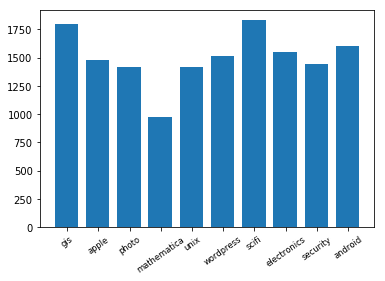

In [31]:
from collections import Counter

labels, values = zip(*Counter(y_pred).items())

indexes = np.arange(len(labels))
width = 0.75

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.025, labels, size='small',rotation=35)
plt.show()